In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from network_revised import DotPerception, build_network
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [2]:
def simulate(
        coherences=[0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512],
        ramp=1,
        threshold=0.5,
        sigma=0.3,
        nActions=2,
        nNeurons=2000,
        rA=4,
        trials=3,
        perception_seed=0,
        network_seed=0,
        dt=0.001,
        dt_sample=0.01,
        relative=0,
        load=False,
        error=('ci', 95),  # ("pi", 50),
        tmax=10,
        condition='normal',  # just for labelling data and plotting empirical validation
        name="default"):
    
    if not load:
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        columns = ('type', 'name', 'trial', 'coherence', 'RT', 'accuracy', 'condition')  # same as Palmer dataframe
        dfs = []
        for coherence in coherences:
            print(f"coherence {coherence}")
            for trial in range(trials):
                # print(f"trial {trial}, coherence {coherence}")
                inputs.create(coherence=coherence)
                net = build_network(inputs, seed=network_seed, nActions=nActions, nNeurons=nNeurons, ramp=ramp, threshold=threshold, relative=relative, rA=rA)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0.01):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > tmax:
                        choice = np.argmax(sim.data[net.pValue][-1,:])
                        RT = sim.trange()[-1]
                correct = True if choice==inputs.correct else False
                # print(RT, 100*correct)
                label = f"ramp {ramp}, thr {threshold}"
                dfs.append(pd.DataFrame([['model', '0', trial, 100*coherence, RT, 100*correct, condition]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{name}_{condition}.pkl")
    else:
        data = pd.read_pickle(f"data/{name}_{condition}.pkl")

    palmer = pd.read_pickle('data/palmer2005.pkl').query("name=='JP' & condition==@condition")
    combined = pd.concat([palmer, data])

    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=((7.08, 2)))
    sns.lineplot(data=combined, x='coherence', y='RT', hue='type', style="type", palette=palette[:2], markers=True, errorbar=error, ax=axes[0])
    sns.lineplot(data=combined, x='coherence', y='accuracy', hue="type", style="type", palette=palette[:2], markers=True, ax=axes[1])  # errorbar=error,
    axes[0].set(xlabel="Coherence (%)", ylabel="Response Time (s)")
    axes[0].set_xscale('log')
    axes[1].set(xlabel="Coherence (%)", xlim=((0.5, 100)), ylabel="Accuracy (%)", ylim=((45, 105)), yticks=((50, 60, 70, 80, 90, 100)))
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/palmer_compare_{name}_{condition}.svg")
    fig.savefig(f"plots/palmer_compare_{name}_{condition}.png", dpi=600)

    if condition=="speed":
        bins = np.arange(0.0, 1.2, 0.2)
    if condition=="normal":
        bins = np.arange(0.0, 2.3, 0.3)
    if condition=="accuracy":
        bins = np.arange(0.0, 4.5, 0.5)
    fig = sns.FacetGrid(combined, col="coherence", hue='type', palette=palette[:2], height=1.5, aspect=1.5, col_wrap=4, sharex=True)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=bins)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    fig.savefig(f"plots/palmer_compare_{name}_{condition}_RTs.svg")
    fig.savefig(f"plots/palmer_compare_{name}_{condition}_RTs.png", dpi=600)

In [3]:
def concat(file1, file2, file3, outfile):
    sim1 = pd.read_pickle(f'data/{file1}.pkl')
    sim2 = pd.read_pickle(f'data/{file2}.pkl')
    sim3 = pd.read_pickle(f'data/{file3}.pkl')
    sim = pd.concat([sim1, sim2, sim3], ignore_index=True)
    sim.to_pickle(f"data/{outfile}.pkl")

In [4]:
def plot(filename, sharex='col'):
    palmer = pd.read_pickle('data/palmer2005.pkl').query("name=='JP'")
    sim = pd.read_pickle(f'data/{filename}.pkl')
    data = pd.concat([palmer, sim])
    coherences = np.sort(data['coherence'].unique())

    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=((7.08, 4)))
    for c, condition in enumerate(['speed', 'normal', 'accuracy']):
        sns.lineplot(data=data.query("condition==@condition"), x='coherence', y='RT', style='type', color=palette[c], markers=True, ax=axes[0][c])
        sns.lineplot(data=data.query("condition==@condition"), x='coherence', y='accuracy', style="type", color=palette[c], markers=True, ax=axes[1][c])
    axes[0][0].set(title="speed", ylabel="Response Time (ms)")
    axes[0][1].set(title="normal", ylabel=None)
    axes[0][2].set(title="accuracy", ylabel=None)
    axes[1][0].set_xscale('log')
    axes[1][0].set(xlabel="Coherence", xlim=((0.5, 100)), ylabel="Accuracy (%)", ylim=((45, 105)), yticks=((50, 60, 70, 80, 90, 100)))
    axes[1][1].set(xlabel="Coherence", xlim=((0.5, 100)), ylabel=None, ylim=((45, 105)), yticks=[])
    axes[1][2].set(xlabel="Coherence", xlim=((0.5, 100)), ylabel=None, ylim=((45, 105)), yticks=[])
    axes[0][1].get_legend().remove()
    axes[0][2].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    axes[1][2].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/compare_palmer_model.svg")
    fig.savefig(f"plots/compare_palmer_model.png", dpi=600)

    fig = sns.FacetGrid(data, col="condition", row="coherence", hue="type", palette=palette[:2], height=1.5, aspect=2, sharex=sharex)
    i=0
    for ax in fig.axes_dict.items():
        coherence = ax[0][0]
        condition = ax[0][1]
        if condition=="speed":
            bins = np.arange(0.0, 1.2, 0.2)
        if condition=="normal":
            bins = np.arange(0.0, 2.3, 0.3)
        if condition=="accuracy":
            bins = np.arange(0.0, 4.5, 0.5)
        sns.histplot(data=data.query("condition==@condition & coherence==@coherence"), x='RT', hue='type',
                     bins=bins, stat='percent', element="poly", common_norm=False, palette=palette[:2], ax=ax[1])
        if i>0: ax[1].get_legend().remove()
        i+=1
    # fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", common_norm=False, bins=8)
    fig.set_xlabels("Reaction Time (s)")
    fig.savefig(f"plots/compare_palmer_model_RTs.svg")
    fig.savefig(f"plots/compare_palmer_model_RTs.png", dpi=600)

## Simulations

### Speed

coherence 0.008
coherence 0.016
coherence 0.032


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(
C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


coherence 0.064
coherence 0.128


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:516: CacheIOWarning: The cache index could not be updated because another program blocked access to it. This is commonly caused by anti-virus software. It is safe to ignore this warning. But if you see it a lot, you might want to consider doing one of the following for the best Nengo performance:
1. Configure your anti-virus to ignore the Nengo cache folder ('C:\Users\Peter Duggins\.nengo\cache\decoders').
2. Disable the cache.

  warnings.warn(


coherence 0.256
coherence 0.512


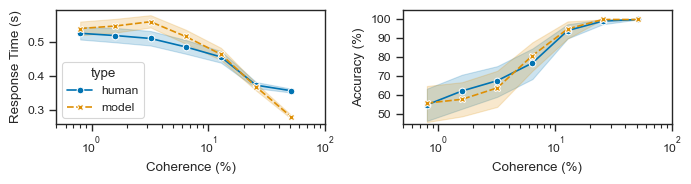

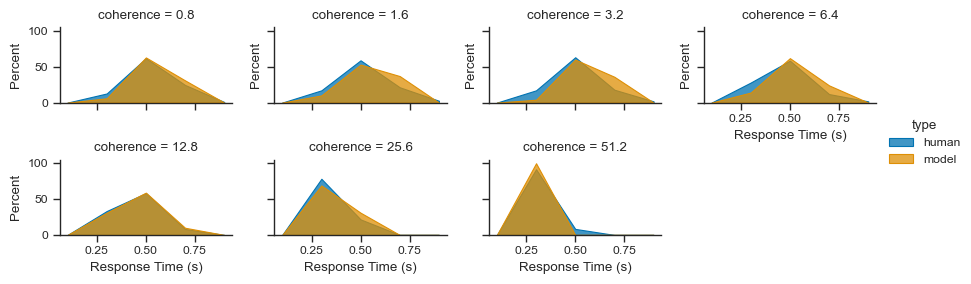

In [5]:
simulate(network_seed=16, perception_seed=113, ramp=1.08, relative=0.65, threshold=0.12, trials=100, name="nov21c", condition="speed", load=False)

coherence 0.008


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


coherence 0.016
coherence 0.032
coherence 0.064
coherence 0.128
coherence 0.256
coherence 0.512


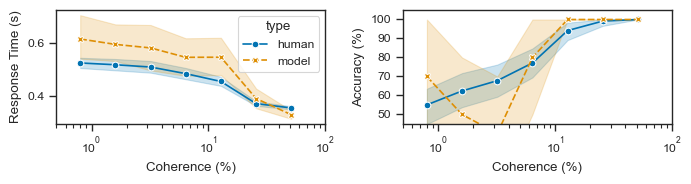

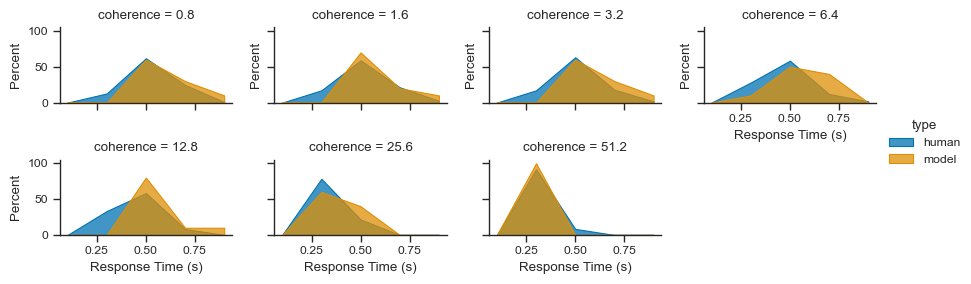

In [5]:
simulate(network_seed=16, perception_seed=113, ramp=1.08, relative=0.65, threshold=0.12, trials=10, name="nov21c2", condition="speed", load=False)

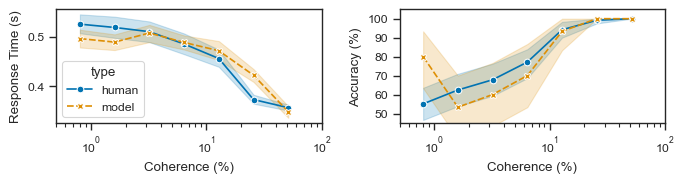

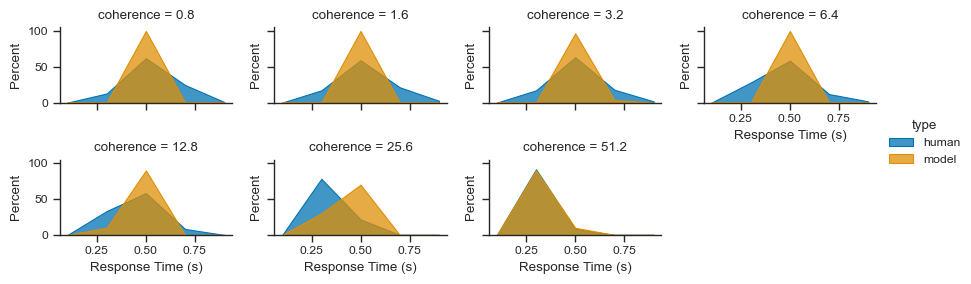

In [32]:
simulate(network_seed=98, perception_seed=28, ramp=1.71, relative=0.22, threshold=0.28, trials=30, name="nov21b", condition="speed", load=True)

coherence 0.008
coherence 0.016
coherence 0.032
coherence 0.064
coherence 0.128
coherence 0.256
coherence 0.512


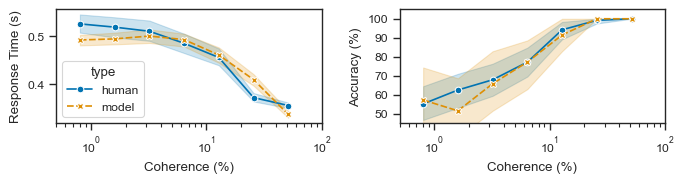

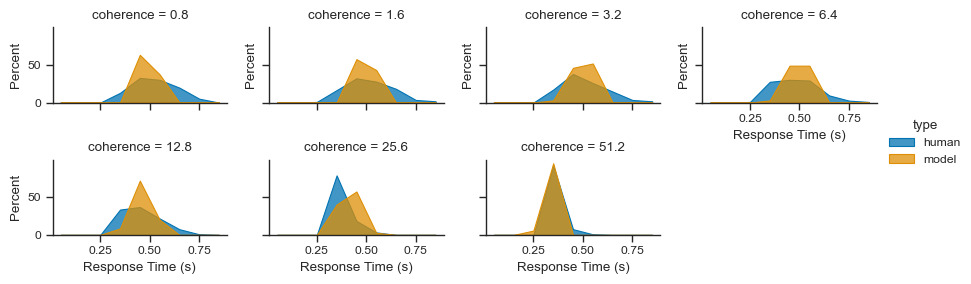

In [5]:
simulate(ramp=1.95, relative=0.27, threshold=0.31, trials=35, name="nov17meansigma", condition="speed", load=False)

coherence 0.008
coherence 0.016
coherence 0.032
coherence 0.064
coherence 0.128
coherence 0.256
coherence 0.512


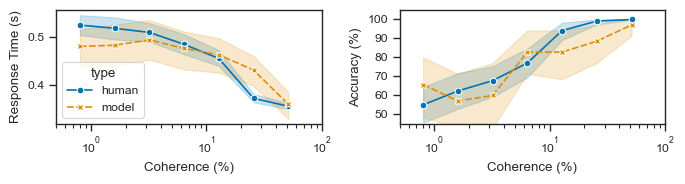

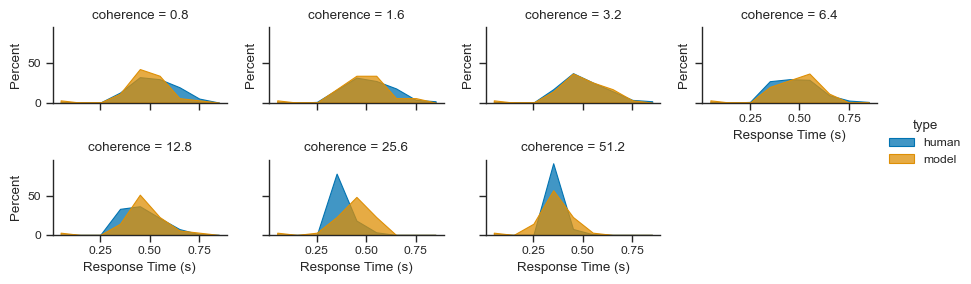

In [6]:
simulate(ramp=0.59, relative=0.3, threshold=0.11, trials=35, name="nov17chisigma", condition="speed", load=False)

coherence 0.008
coherence 0.016
coherence 0.032
coherence 0.064
coherence 0.128
coherence 0.256
coherence 0.512


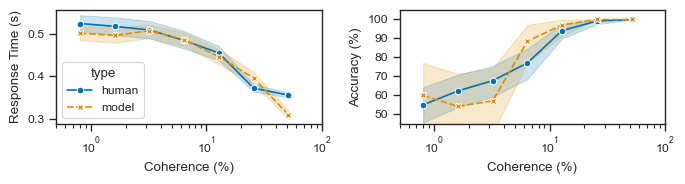

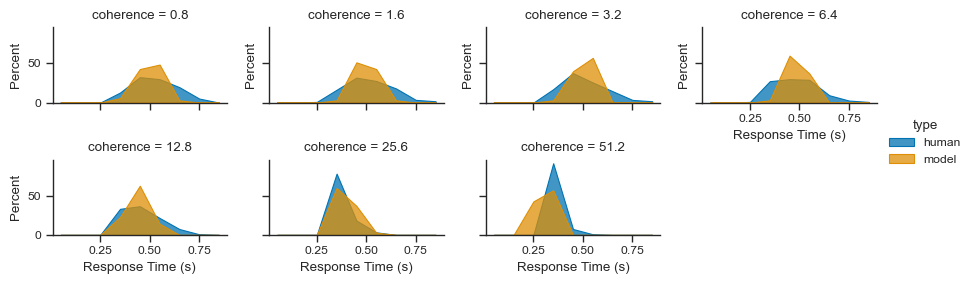

In [9]:
simulate(ramp=1.69, relative=0.41, threshold=0.23, trials=35, name="nov17meansigma", condition="speed", load=False)

### Normal

coherence 0.008


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(
C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(
C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:516: CacheIOWarning: The cache index could not be updated because another program blocked access to it. This is commonly caused by anti-virus software. It is safe to ignore this warning. But if you see it a lot, you might want to consider doing one of the following for the best Nengo performance:
1. Configure your anti-virus to ignore the Nengo cache folder ('C:\Users\Peter Duggins\.nengo\cache\decoders').
2. Disable the cache.

  warnings.warn(


coherence 0.016
coherence 0.032
coherence 0.064
coherence 0.128
coherence 0.256
coherence 0.512


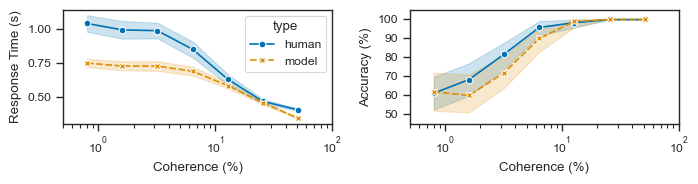

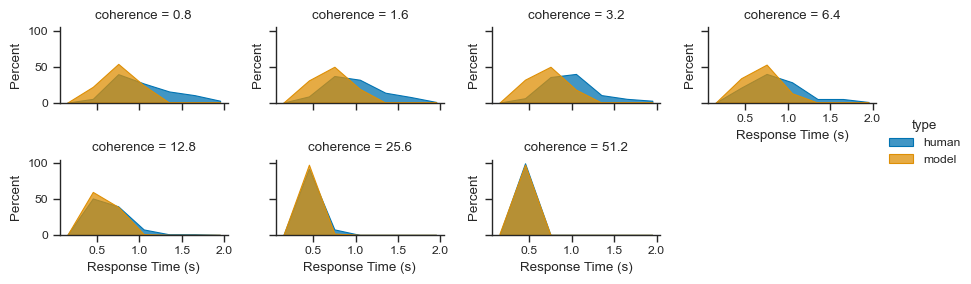

In [6]:
simulate(network_seed=685, perception_seed=309, ramp=1.89, relative=0.67, threshold=0.28, trials=100, name="nov21c", condition="normal", load=False)

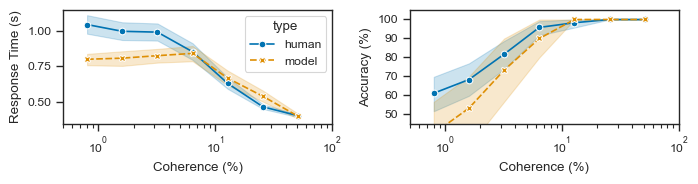

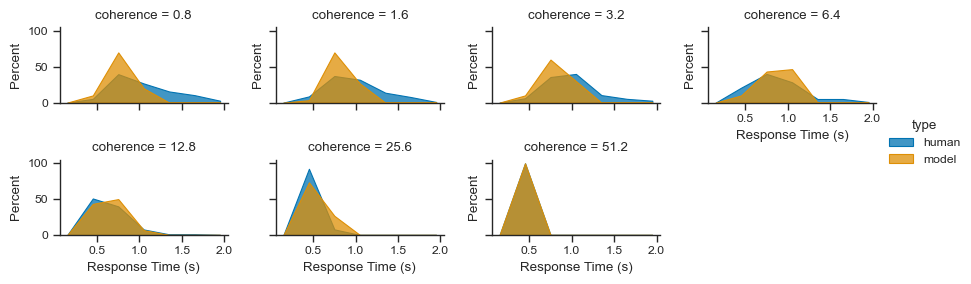

In [36]:
simulate(network_seed=98, perception_seed=20, ramp=1.56, relative=0.63, threshold=0.26, trials=30, name="nov21a", condition="normal", load=True)

coherence 0.008
coherence 0.016
coherence 0.032
coherence 0.064
coherence 0.128
coherence 0.256
coherence 0.512


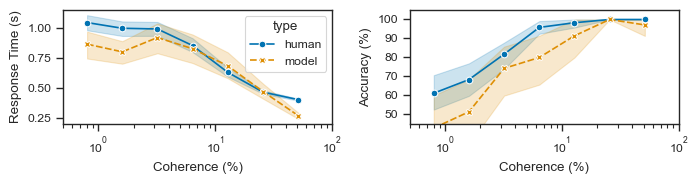

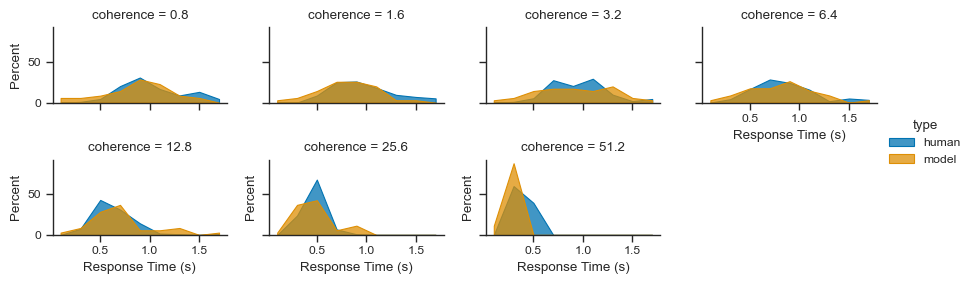

In [7]:
simulate(ramp=0.88, relative=0.88, threshold=0.1, trials=35, name="nov17chisigma", condition="normal", load=False)

coherence 0.008
coherence 0.016
coherence 0.032
coherence 0.064
coherence 0.128
coherence 0.256
coherence 0.512


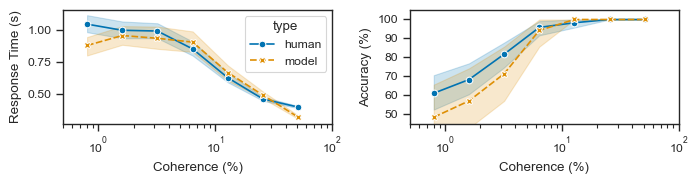

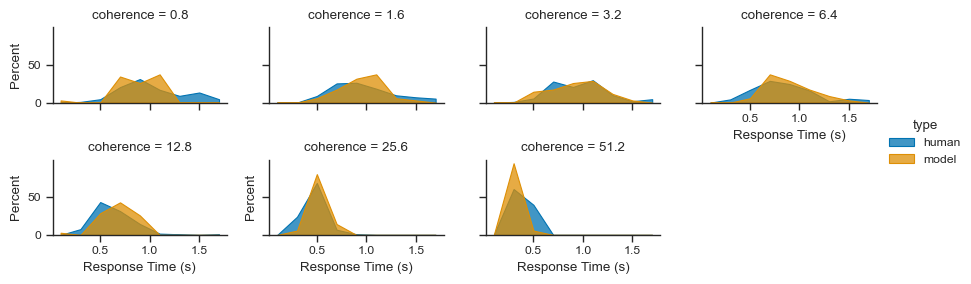

In [8]:
simulate(ramp=1.48, relative=0.77, threshold=0.19, trials=35, name="nov17meansigma", condition="normal", load=False)

### Accuracy

coherence 0.008
coherence 0.016
coherence 0.032
coherence 0.064
coherence 0.128
coherence 0.256
coherence 0.512


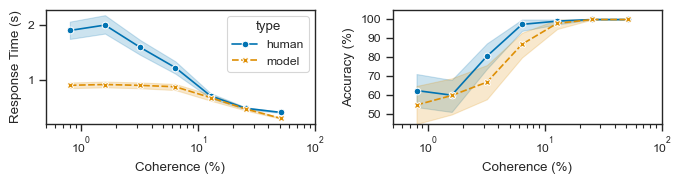

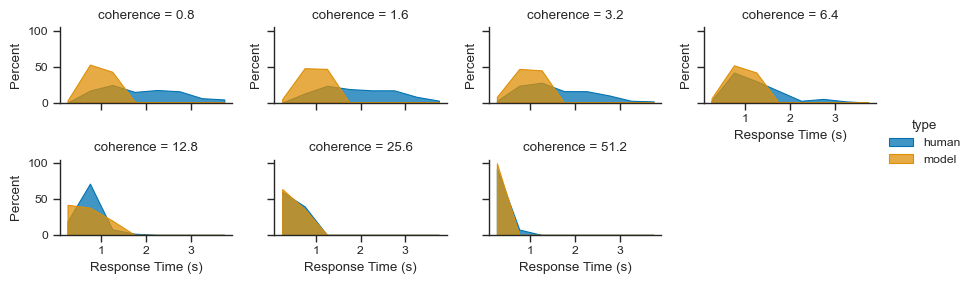

In [7]:
simulate(network_seed=719, perception_seed=157, ramp=1.14, relative=0.79, threshold=0.15, trials=100, name="nov21c", condition="accuracy", load=False)

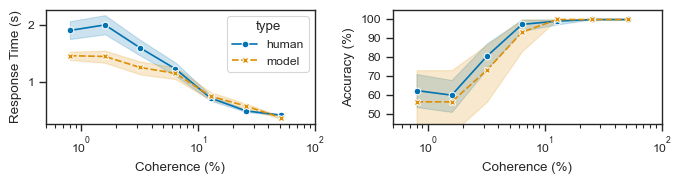

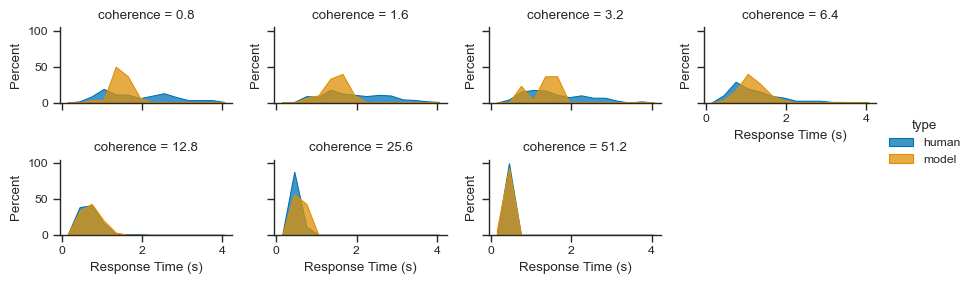

In [46]:
simulate(network_seed=17, perception_seed=36, ramp=1.02, relative=0.82, threshold=0.16, trials=30, name="nov21b", condition="accuracy", load=True)

coherence 0.008


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(
C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(
C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")
C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:516: CacheIOWarning: The cache index could not be updated because another program blocked access to it. This is commonly caused by anti-virus software. It is safe to ignore this warning. But if you see it a lot, you might want to consider doing one of the following for the best Nengo performan

coherence 0.016
coherence 0.032
coherence 0.064
coherence 0.128
coherence 0.256
coherence 0.512


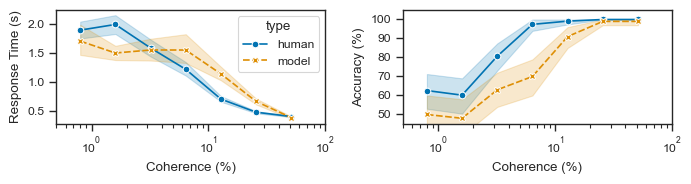

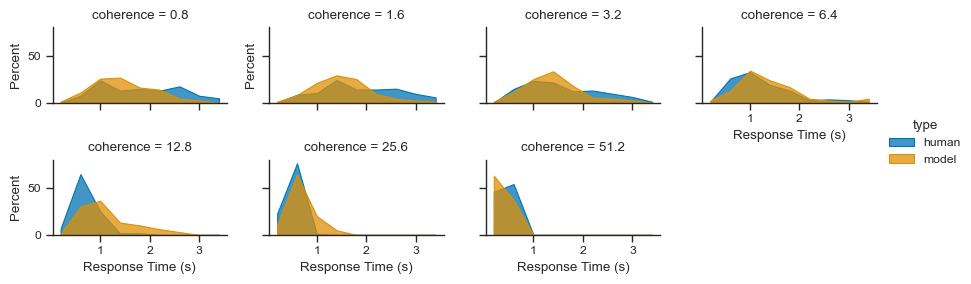

In [5]:
simulate(ramp=0.78, relative=0.92, threshold=0.12, trials=100, name="nov17chisigma", condition="accuracy", load=False)

coherence 0.008
coherence 0.016
coherence 0.032
coherence 0.064
coherence 0.128
coherence 0.256
coherence 0.512


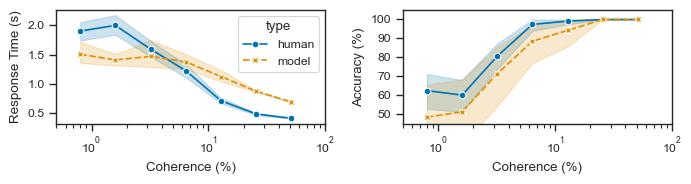

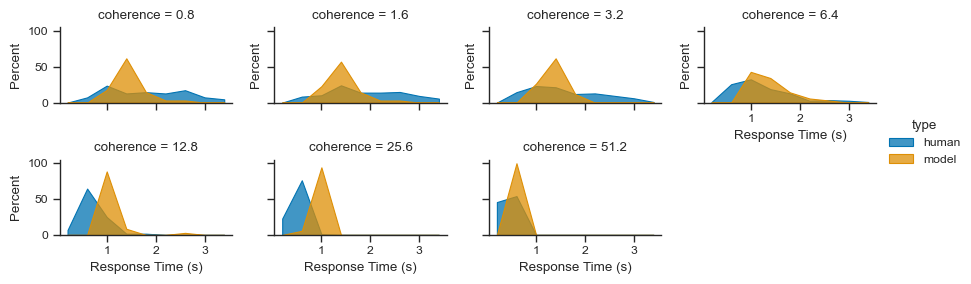

In [5]:
simulate(ramp=1.81, relative=0.14, threshold=0.77, trials=35, name="nov17meansigma", condition="accuracy", load=False)

## Final Plot

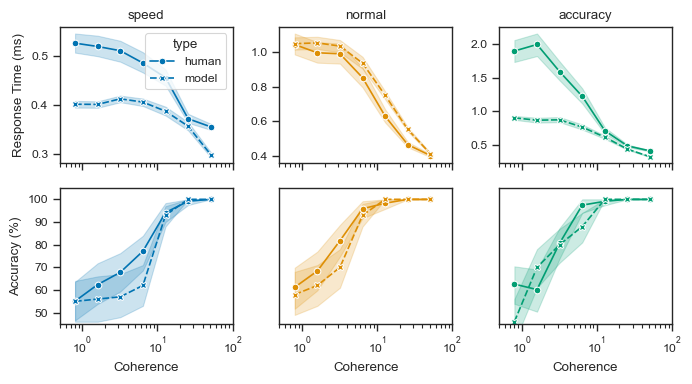

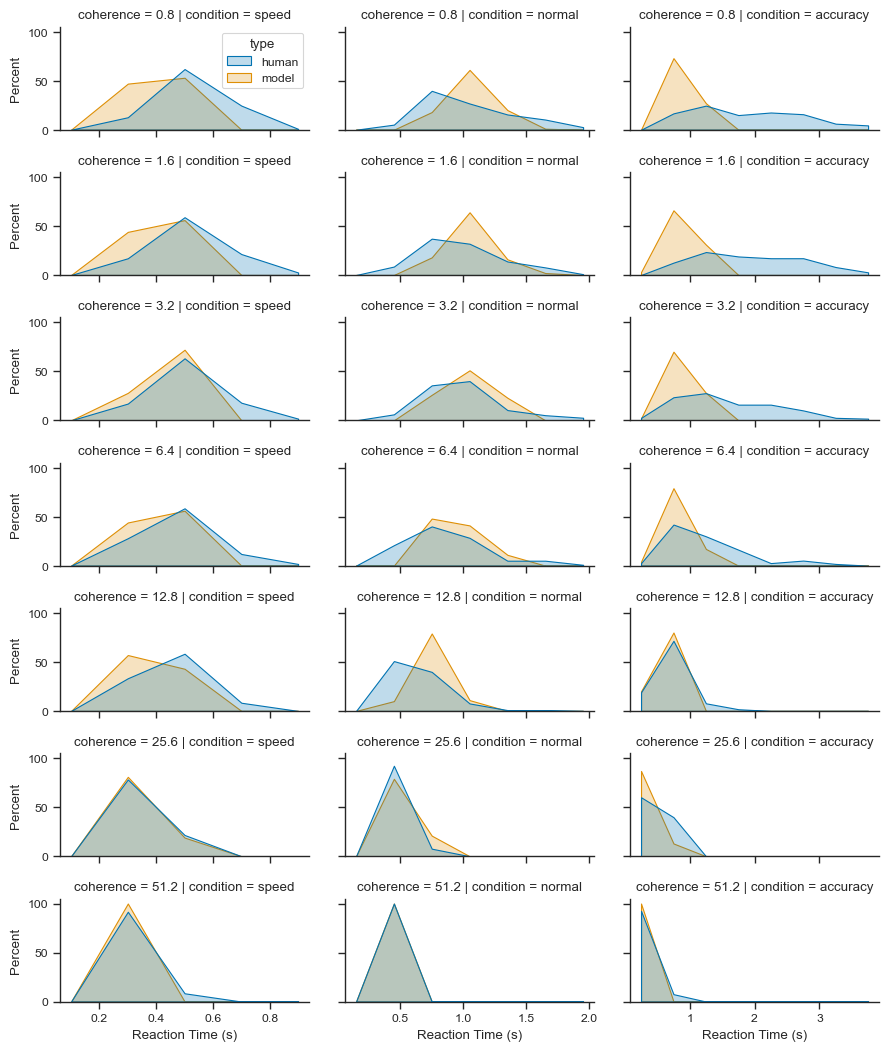

In [53]:
concat("nov21c_speed", "nov21c_normal", "nov21c_accuracy", "nov21c")
plot("nov21c")

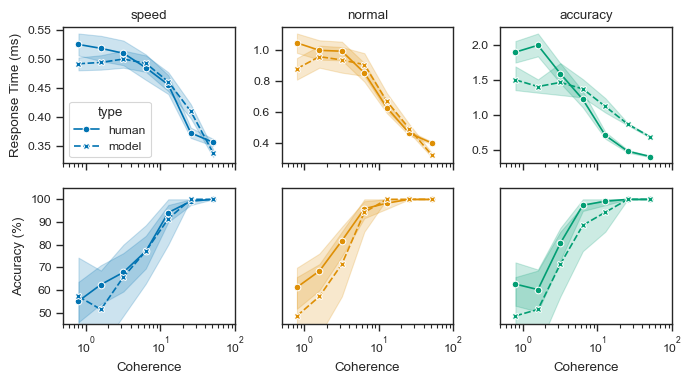

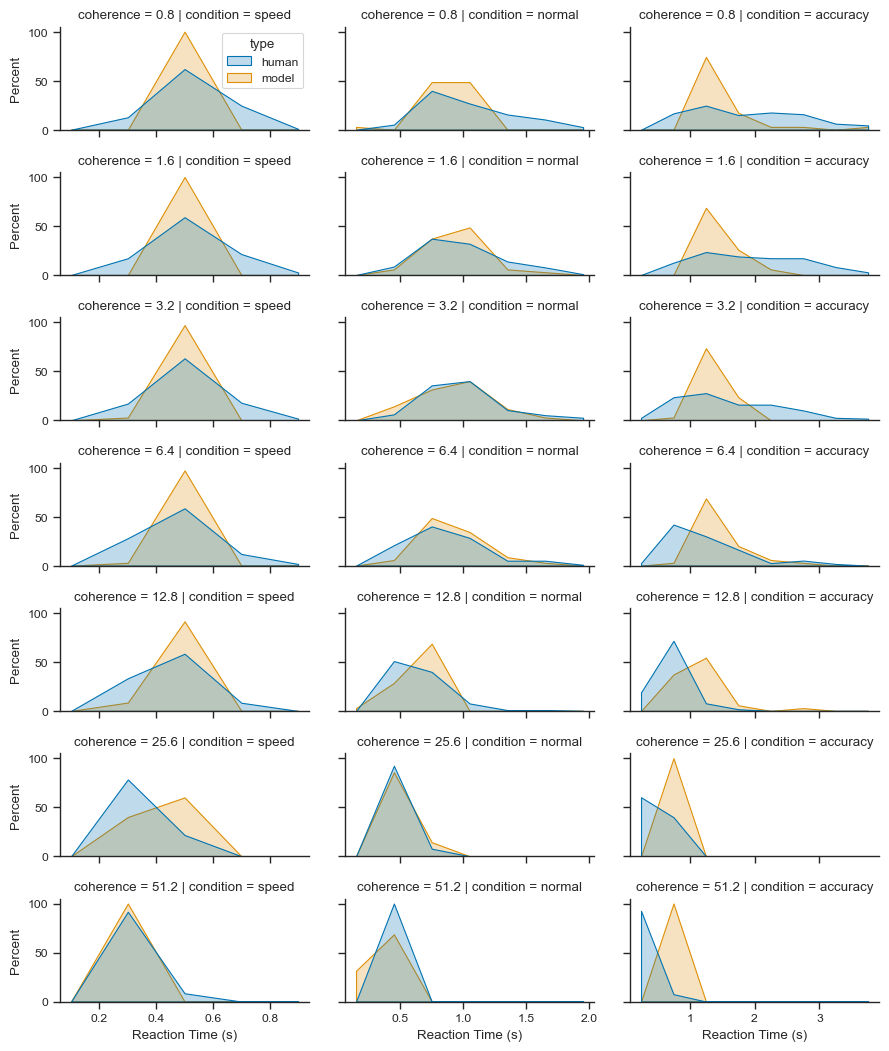

In [48]:
concat("nov17meansigma_speed", "nov17meansigma_normal", "nov17meansigma_accuracy", "nov17mean")
plot("nov17mean")